In [7]:
# Import libraries and set desired options

from __future__ import division, print_function
# Disable Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import FastICA

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [8]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [9]:
def analyze_results(cv_res):
    import re 
    
    results = pd.DataFrame(cv_res['params'])
    results['mean_score'] = cv_res['mean_test_score']
    results['std_score'] = cv_res['std_test_score']
    results['rank'] = cv_res['rank_test_score']
#     results = results.sort_values('rank')
    
    n_splits = len(cv_res['split0_test_score'])
    cv_results = np.r_[[clf.cv_results_[k] for k in clf.cv_results_.keys() if re.match(r'split\d+_test', k)]]
    cv_results = pd.DataFrame(cv_results)
    melted = cv_results.melt()
    melted['split_num'] = list(range(cv_results.shape[0])) * cv_results.shape[1]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'width_ratios':[2, 1]})
    
    sns.barplot(x='split_num', y='value', hue='variable', data=melted, ax=axes[0, 0]);
    axes[0, 0].set_ylim(melted['value'].min()-.01, 1);
    
    sns.violinplot(x='variable', y='value', hue='variable', data=cv_results.melt(), ax=axes[0, 1], dodge=False);
    sns.boxplot(x='variable', y='value', data=melted, ax=axes[1, 0]);
    sns.barplot(x=results.index, y='std_score', data=results, ax=axes[1, 1]);
    
    sns.despine()
    return results, cv_results

## Load data

In [10]:
# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [11]:
# Read the training and test data sets
train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id')

In [12]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [13]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Dataframe with indices of visited websites in session
full_sites = full_df[sites]

# Index to split the training and test data sets
idx_split = train_df.shape[0]

### get time features

In [24]:
def get_time_features(df):
    time_df = pd.DataFrame(index=df.index)
    
    hour = df['time1'].apply(lambda ts: ts.hour)
    time_df['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
    time_df['day'] = ((hour >= 12) & (hour <= 18)).astype('int')
    time_df['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')

#     time_df['minutes'] = df['time1'].dt.hour * 60 + df['time1'].dt.minute
#     time_df['dow'] = df['time1'].apply(lambda ts: ts.date().weekday())
#     dtimes = ['dt'+str(i) for i in range(2, 11)]
#     for i in range(2, 11):
#         time_df['dt'+str(i)] = (df['time'+str(i)] - df['time'+str(i-1)]).astype('timedelta64[s]')
#     time_df['dt'] = time_df[dtimes].mean(axis=1)
#     time_df['dt_std'] = time_df[dtimes].std(axis=1)

    return time_df

In [25]:
full_time = get_time_features(full_df[times])
ft_columns = full_time.columns

# hours_dum = pd.get_dummies(pd.cut(full_time['hour'], bins=4, labels=['1', '2', '3', '4']), prefix='spl', prefix_sep='')
# full_time = pd.concat([full_time, hours_dum], axis=1)
print(ft_columns)

Index(['morning', 'day', 'evening'], dtype='object')


### get site features

In [26]:
text_cols = ['sites_num']
df_text = pd.DataFrame(columns=text_cols)
df_text['sites_num'] = full_sites.astype('str').apply(lambda x: ' '.join(x), axis=1)

### concat features

In [27]:
X_train = pd.concat([df_text.iloc[:idx_split], full_time.iloc[:idx_split]], axis=1)
X_test = pd.concat([df_text.iloc[idx_split:], full_time.iloc[idx_split:]], axis=1)

X_train.tail(1)

,sites_num,morning,day,evening
session_id,,,,
204762,222 3346 3346 3359 55 2891 3346 0 0 0,0,0,1


In [28]:
X_train.columns

Index(['sites_num', 'morning', 'day', 'evening'], dtype='object')

# Pipeline

In [29]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [110]:
pl_text_tfidf = Pipeline([
                ('select', TextSelector(key='sites_num')),
#                 ('tfidf', TfidfVectorizer(max_df=0.2, max_features=8000, smooth_idf=True, sublinear_tf=True)),
#                 ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000))
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000, 
                                          smooth_idf=True, binary=True, sublinear_tf=True))
#                     ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=30000, max_df=0.15))
                ])

pl_text_count = Pipeline([
                ('select', TextSelector(key='sites_num')),
                ('count', CountVectorizer(ngram_range=(1, 3), max_features=50000))
                ])

pl_time = Pipeline([
                ('select', NumberSelector(key=ft_columns))
                ])

pl_time_scale = Pipeline([
                ('select', NumberSelector(key=ft_columns)),
                ('scale', StandardScaler())
                ])

pl_ica = Pipeline([
            ('select', NumberSelector(key=ft_columns)),
            ('scale', StandardScaler()),
            ('ica', FastICA(n_components=3, random_state=17))
            ])
# sklearn.decomposition.TruncatedSVD

feats = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
#                     ('pl_time', pl_time),
                    ('pl_time_scale', pl_time_scale)
                    ])


feats_ns = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
                    ('pl_time', pl_time),
#                     ('pl_time_scale', pl_time_scale)
                    ])

feats_all = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
                    ('pl_time', pl_time),
                    ('pl_time_scale', pl_time_scale)
                    ])

pl = Pipeline([
                ('feats', feats),
                ('clf', LogisticRegression(random_state=17))
              ])

pl_ns = Pipeline([
                ('feats', feats_ns),
                ('clf', LogisticRegression(random_state=17))
              ])

pl_all = Pipeline([
                ('feats', feats_all),
                ('clf', LogisticRegression(random_state=17))
              ])

In [58]:
[x for x in pl_ns.get_params().keys() if 'tfidf' in x]

['feats__pl_text__tfidf',
 'feats__pl_text__tfidf__analyzer',
 'feats__pl_text__tfidf__binary',
 'feats__pl_text__tfidf__decode_error',
 'feats__pl_text__tfidf__dtype',
 'feats__pl_text__tfidf__encoding',
 'feats__pl_text__tfidf__input',
 'feats__pl_text__tfidf__lowercase',
 'feats__pl_text__tfidf__max_df',
 'feats__pl_text__tfidf__max_features',
 'feats__pl_text__tfidf__min_df',
 'feats__pl_text__tfidf__ngram_range',
 'feats__pl_text__tfidf__norm',
 'feats__pl_text__tfidf__preprocessor',
 'feats__pl_text__tfidf__smooth_idf',
 'feats__pl_text__tfidf__stop_words',
 'feats__pl_text__tfidf__strip_accents',
 'feats__pl_text__tfidf__sublinear_tf',
 'feats__pl_text__tfidf__token_pattern',
 'feats__pl_text__tfidf__tokenizer',
 'feats__pl_text__tfidf__use_idf',
 'feats__pl_text__tfidf__vocabulary']

In [126]:
%%time

params = {
    'clf__C': np.logspace(-0.3, .7, 4),   # np.logspace(-1, 1, 6) 
#     'feats__pl_text__tfidf__max_df': [0.15],
#     'feats__pl_text__tfidf__min_df': np.logspace(-5, -1, 5),
#     'feats__pl_text__tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)]
#     'feats__pl_text__tfidf__max_features': [30000, 50000, 70000]# np.arange(10000, 100000, 20000)
#     'feats__pl_text__tfidf__smooth_idf': [True, False],
#     'feats__pl_text__tfidf__sublinear_tf': [True, False],
#     'feats__pl_text__tfidf__binary': [True, False]
    
        }

time_split = TimeSeriesSplit(n_splits=10)

clf = GridSearchCV(pl_ns, params, cv=time_split, verbose=1, scoring='roc_auc', n_jobs=-1)

clf.fit(X_train, y_train)

print(clf.best_params_, clf.best_score_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


{'clf__C': 2.326305067153626} 0.9261085040325898
CPU times: user 28.5 s, sys: 795 ms, total: 29.3 s
Wall time: 2min 20s


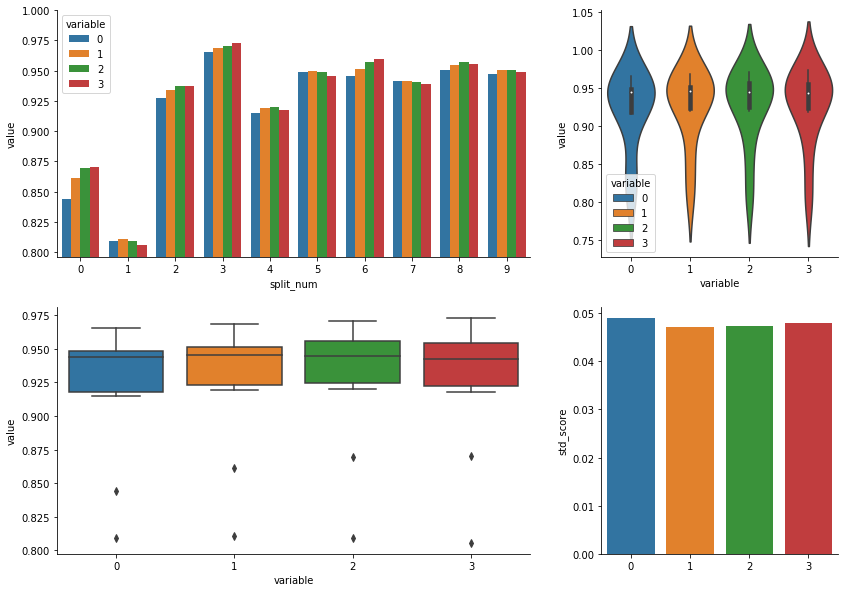

In [127]:
results, cv_results = analyze_results(clf.cv_results_)

In [128]:
# clf C
results.sort_values('rank')

,clf__C,mean_score,std_score,rank
2,2.326305,0.926109,0.047262,1
3,5.011872,0.925368,0.048055,2
1,1.079775,0.924156,0.047234,3
0,0.501187,0.919484,0.048907,4


In [129]:
clf.refit

pred = clf.predict_proba(X_test)[:, 1]

write_to_submission_file(pred, 'pred_2910_tf_3.csv')

#### PUBLIC SCORE 0.94730

`pl_text_tfidf = Pipeline([('select', TextSelector(key='sites_num')),
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000,   
                smooth_idf=True, binary=True, sublinear_tf=True))])`  
{'clf__C': 2.326305067153626} 0.9261085040325898  
rs = 17  
Index(['sites_num', 'morning', 'day', 'evening'], dtype='object')  